# Scheduling transpiler pass upgrade

Qiskit demoday (Mar. 17. 2022)

Naoki Kanazawa (@Naoki Kanazawa)

#### Relevant PRs:

- Fix ASAP/ALAP scheduling pass ([qiskit-terra/#7655](https://github.com/Qiskit/qiskit-terra/pull/7655), merged)

- Split scheduling pass into scheduling and padding ([qiskit-terra/#7709](https://github.com/Qiskit/qiskit-terra/pull/7709), merged)

- Dynamical Decoupling pass with pulse alignment ([qiskit-terra/#7760](https://github.com/Qiskit/qiskit-terra/pull/7760))
  
- [WIP] Replace AlignMeasures with ConstrainedReschedule for pulse alignment ([qiskit-terra/#7762](https://github.com/Qiskit/qiskit-terra/pull/7762))

#### TODO:
- Timeline drawer updates

### Background

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 1)
qc.sx(0)
qc.delay(100, 0)
qc.cx(0, 1)
qc.measure(1, 0)

qc.draw()

┌────┐┌────────────────┐        
q_0: ┤ √X ├┤ Delay(100[dt]) ├──■─────
     └────┘└────────────────┘┌─┴─┐┌─┐
q_1: ────────────────────────┤ X ├┤M├
                             └───┘└╥┘
c: 1/══════════════════════════════╩═
                                   0

This circuit cannot be executed on a real hardware. In IBM Quantum backends, waveform data is stored in the memory chunked with 16 datapoints to realize high AWG bandwidth at 4.5 GSps. This chunk size appears in `timing_constraints`.

In [2]:
from qiskit.test.mock import FakeWashington

FakeWashington().configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 16}

This hardware implementation introduces extra scheduling constraints at microarchitecture level, `acquire_alignment` and `pulse_alignment`.

- `Measure` instruction should start at t0 that is multiple of 16dt (acquire alignment)
- `Gate` instruction should start at t0 that is multiple of 16dt (pulse alignment).

Previously IBM hardwares had `pulse_alignment=1` (i.e. no constraints on gate start time), but recent hardware started to impose `pulse_alignment=16`. For example, dynamical decoupling pass cannot take arbitrary echo-gate intervals.

This is where alignment passes come into play. Currently we only have alignment for acquire constraint.

- Schedule > Alignment 

In [2]:
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler.passes import ALAPSchedule, AlignMeasures
from qiskit.transpiler.instruction_durations import InstructionDurations

durations = InstructionDurations([("sx", (0, ), 160), ("cx", (0, 1), 800), ("measure", (1, ), 1600)])

First the circuit is scheduled

In [3]:
# this is as of Qiskit v0.19
pm = PassManager([ALAPSchedule(durations)])
pm.run(qc).draw()

┌────┐      ┌────────────────┐     ┌─────────────────┐
q_0: ──────┤ √X ├──────┤ Delay(100[dt]) ├──■──┤ Delay(1600[dt]) ├
     ┌─────┴────┴─────┐└────────────────┘┌─┴─┐└───────┬─┬───────┘
q_1: ┤ Delay(260[dt]) ├──────────────────┤ X ├────────┤M├────────
     └────────────────┘                  └───┘        └╥┘        
c: 1/══════════════════════════════════════════════════╩═════════
                                                       0

Then aligned.

In [4]:
# this is as of Qiskit v0.19
pm = PassManager([ALAPSchedule(durations), AlignMeasures(alignment=16)])
pm.run(qc).draw()

┌────┐      ┌────────────────┐     ┌─────────────────┐   
q_0: ──────┤ √X ├──────┤ Delay(100[dt]) ├──■──┤ Delay(1612[dt]) ├───
     ┌─────┴────┴─────┐└────────────────┘┌─┴─┐└┬───────────────┬┘┌─┐
q_1: ┤ Delay(260[dt]) ├──────────────────┤ X ├─┤ Delay(12[dt]) ├─┤M├
     └────────────────┘                  └───┘ └───────────────┘ └╥┘
c: 1/═════════════════════════════════════════════════════════════╩═
                                                                  0

Note that scheduling is done in relative timing, i.e. by adding delays in between gates:

- All transpiler passes had been `TransformationPass`, which always create new `DAGCircuit`. 
- We needed to sum up all DAGOpNode duration on the wire to evaluate constraint (i.e. it is applied to t0)


In addition, current scheduling doesn't support control flow. This will be important to accurately simulate dynamic circuit.

In [5]:
FakeWashington().configuration().conditional_latency

[]

In [6]:
FakeWashington().configuration().acquisition_latency

[]

### Realistic control flow support

Let's check the behavior of following circuit.

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 1)
qc.x(0)
qc.measure(0, 0)
qc.x(0).c_if(0, 0)
qc.measure(1, 0)

qc.draw()

┌───┐┌─┐   ┌───┐      
q_0: ┤ X ├┤M├───┤ X ├──────
     └───┘└╥┘   └─╥─┘   ┌─┐
q_1: ──────╫──────╫─────┤M├
           ║ ┌────╨────┐└╥┘
c: 1/══════╩═╡ c_0=0x0 ╞═╩═
           0 └─────────┘ 0

In [2]:
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.transpiler.instruction_durations import InstructionDurations
from qiskit.visualization import timeline_drawer

durations = InstructionDurations([("x", None, 160), ("measure", None, 1600)])

It doesn't seem that the topoligical ordering of nodes is preserved in the schedule view. However, we can confirm it is actually preserved. Here nodes only share the classical bit `c0`.

Define: instrucion timeslot (`t0`, `t1`)
- `Measure` instruction accesses `c0` at `t1`
- Conditional operation `X` accesses `c0` at `t0`

In [3]:
# this is as of Qiskit v0.19
pm = PassManager([ALAPSchedule(durations)])
qc_scheduled = pm.run(qc)
qc_scheduled.draw()

┌───┐       ┌─┐   ┌───┐      
q_0: ──────┤ X ├───────┤M├───┤ X ├──────
     ┌─────┴───┴──────┐└╥┘   └─╥─┘   ┌─┐
q_1: ┤ Delay(320[dt]) ├─╫──────╫─────┤M├
     └────────────────┘ ║ ┌────╨────┐└╥┘
c: 1/═══════════════════╩═╡ c_0=0x0 ╞═╩═
                        0 └─────────┘ 0

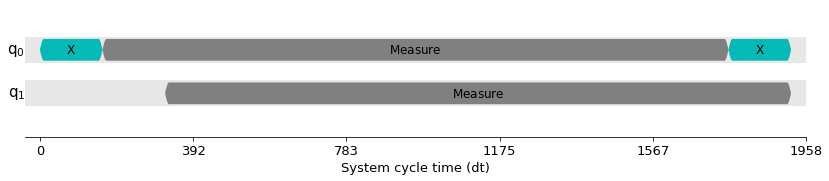

In [4]:
# this is as of Qiskit v0.19
timeline_drawer(qc_scheduled)

Let's check another example (just removed conditional gate. Pulse IR doesn't support control flow).

In [5]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 1)
qc.x(0)
qc.measure(0, 0)
qc.measure(1, 0)

qc.draw()

┌───┐┌─┐   
q_0: ┤ X ├┤M├───
     └───┘└╥┘┌─┐
q_1: ──────╫─┤M├
           ║ └╥┘
c: 1/══════╩══╩═
           0  0

In [6]:
# this is as of Qiskit v0.19
pm = PassManager([ALAPSchedule(durations)])
qc_scheduled = pm.run(qc)
qc_scheduled.draw()

┌───┐       ┌─┐   
q_0: ──────┤ X ├───────┤M├───
     ┌─────┴───┴──────┐└╥┘┌─┐
q_1: ┤ Delay(160[dt]) ├─╫─┤M├
     └────────────────┘ ║ └╥┘
c: 1/═══════════════════╩══╩═
                        0  0

When we schedule this circuit, it causes an error since pulse doesn't accept accessing the same memory slot at the same time.

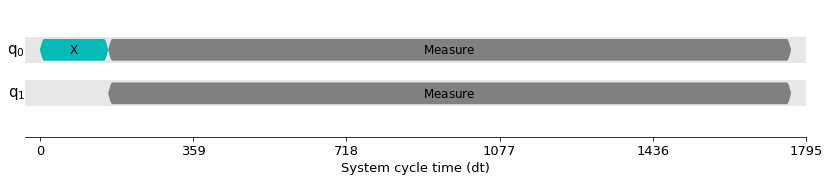

In [7]:
# this is as of Qiskit v0.19
timeline_drawer(qc_scheduled)

In [8]:
# this is as of Qiskit v0.19

from qiskit import schedule
from qiskit.test.mock import FakeBelem

try:
    sched = schedule(qc, FakeBelem())
except Exception as ex:
    print(ex)

"Schedule(name='') cannot be inserted into Schedule(name='Default measurement schedule for qubits [0, 1]') at time 0 because its instruction on channel MemorySlot(0) scheduled from time 0 to 22400 overlaps with an existing instruction."


This means circuit scheduling and pulse scheduling have different policy.

## qiskit-terra/#7655 + #7709 + #7762 (wip)

In this PR, scheduling passes are converted into `AnalysisPass` where the absolute time information is created in the property set.

### Alignment (reschedule)

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 1)
qc.sx(0)
qc.delay(100, 0)
qc.cx(0, 1)
qc.measure(1, 0)

qc.draw()

┌────┐┌────────────────┐        
q_0: ┤ √X ├┤ Delay(100[dt]) ├──■─────
     └────┘└────────────────┘┌─┴─┐┌─┐
q_1: ────────────────────────┤ X ├┤M├
                             └───┘└╥┘
c: 1/══════════════════════════════╩═
                                   0

In [29]:
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler.passes import ALAPSchedule, PadDelay, ConstrainedReschedule
from qiskit.transpiler.instruction_durations import InstructionDurations

durations = InstructionDurations([("sx", (0, ), 160), ("cx", (0, 1), 800), ("measure", (1, ), 1600)])

In [3]:
pm = PassManager([ALAPSchedule(durations)])
pm.run(qc).draw()

┌────┐┌────────────────┐        
q_0: ┤ √X ├┤ Delay(100[dt]) ├──■─────
     └────┘└────────────────┘┌─┴─┐┌─┐
q_1: ────────────────────────┤ X ├┤M├
                             └───┘└╥┘
c: 1/══════════════════════════════╩═
                                   0

Because `ALAPSchedule` is now turned into analysis pass, this doesn't change circuit. Instead,

In [25]:
for node, t in pm.property_set["node_start_time"].items():
    print(f"{t :4d} dt: {node.name} ({node.qargs} {node.cargs})")

1060 dt: measure ([Qubit(QuantumRegister(2, 'q'), 1)] [Clbit(ClassicalRegister(1, 'c'), 0)])
 260 dt: cx ([Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)] [])
 160 dt: delay ([Qubit(QuantumRegister(2, 'q'), 0)] [])
   0 dt: sx ([Qubit(QuantumRegister(2, 'q'), 0)] [])


Reschedule pass now just update this dictionary.

In [30]:
pm = PassManager(
    [
        ALAPSchedule(durations), 
        ConstrainedReschedule(acquire_alignment=16, pulse_alignment=16),
    ]
)
pm.run(qc).draw()

┌────┐┌────────────────┐        
q_0: ┤ √X ├┤ Delay(100[dt]) ├──■─────
     └────┘└────────────────┘┌─┴─┐┌─┐
q_1: ────────────────────────┤ X ├┤M├
                             └───┘└╥┘
c: 1/══════════════════════════════╩═
                                   0

In [31]:
for node, t in pm.property_set["node_start_time"].items():
    print(f"{t :4d} dt: {node.name} ({node.qargs} {node.cargs})")

1072 dt: measure ([Qubit(QuantumRegister(2, 'q'), 1)] [Clbit(ClassicalRegister(1, 'c'), 0)])
 272 dt: cx ([Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)] [])
 160 dt: delay ([Qubit(QuantumRegister(2, 'q'), 0)] [])
   0 dt: sx ([Qubit(QuantumRegister(2, 'q'), 0)] [])


To reflect schedule information to the program, we need padding passes at the end of pass manager passes. Note that QASM is not aware of absolute instruction timing. Here `PadDelay` pass inserts `Delay` in idle times.

In [32]:
pm = PassManager(
    [
        ALAPSchedule(durations), 
        ConstrainedReschedule(acquire_alignment=16, pulse_alignment=16),
        PadDelay(),
    ]
)
pm.run(qc).draw()

┌────┐      ┌────────────────┐     ┌─────────────────┐
q_0: ──────┤ √X ├──────┤ Delay(112[dt]) ├──■──┤ Delay(1600[dt]) ├
     ┌─────┴────┴─────┐└────────────────┘┌─┴─┐└───────┬─┬───────┘
q_1: ┤ Delay(272[dt]) ├──────────────────┤ X ├────────┤M├────────
     └────────────────┘                  └───┘        └╥┘        
c: 1/══════════════════════════════════════════════════╩═════════
                                                       0

### Control flow
Now scheduling passes take `clbit_write_latency`, `conditional_latency`.

In [36]:
from qiskit import QuantumCircuit
from qiskit.visualization import timeline_drawer

durations = InstructionDurations([("x", None, 160), ("measure", None, 1600)])

qc = QuantumCircuit(2, 1)
qc.x(0)
qc.measure(0, 0)
qc.x(0).c_if(0, 0)
qc.measure(1, 0)

pm = PassManager(
    [
        ALAPSchedule(durations), 
        PadDelay(),
    ]
)
qc_scheduled = pm.run(qc)
qc_scheduled.draw()

┌───┐       ┌─┐   ┌───┐   ┌─────────────────┐
q_0: ───────┤ X ├───────┤M├───┤ X ├───┤ Delay(1440[dt]) ├
     ┌──────┴───┴──────┐└╥┘   └─╥─┘   └───────┬─┬───────┘
q_1: ┤ Delay(1760[dt]) ├─╫──────╫─────────────┤M├────────
     └─────────────────┘ ║ ┌────╨────┐        └╥┘        
c: 1/════════════════════╩═╡ c_0=0x0 ╞═════════╩═════════
                         0 └─────────┘         0

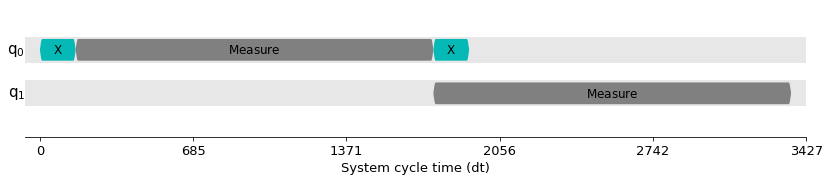

In [37]:
timeline_drawer(qc_scheduled)

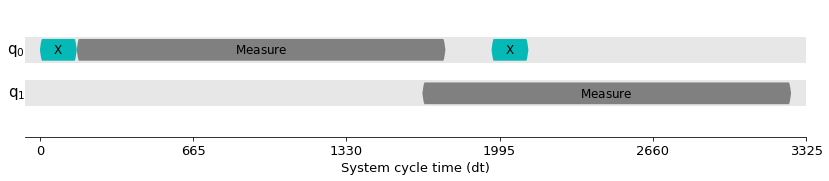

In [40]:
pm = PassManager(
    [
        ALAPSchedule(durations, clbit_write_latency=300, conditional_latency=200), 
        PadDelay(),
    ]
)
qc_scheduled = pm.run(qc)
timeline_drawer(qc_scheduled)

Reproducing Qiskit-terra 0.19, i.e. `clbit_write_latency = t1`

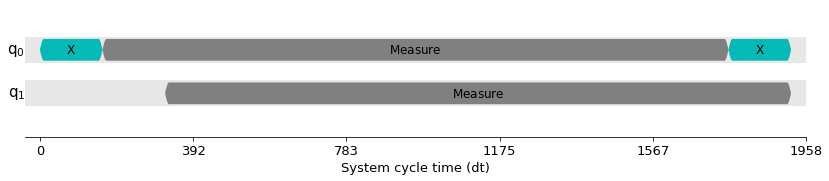

In [41]:
pm = PassManager(
    [
        ALAPSchedule(durations, clbit_write_latency=1600, conditional_latency=0), 
        PadDelay(),
    ]
)
qc_scheduled = pm.run(qc)
timeline_drawer(qc_scheduled)

## qiskit-terra/#7760 (ready)

Now `DynamicalDecoupling` pass is redesigned as a subclass of `BasePadding` pass. 

- `PadDelay`: Insert `Delay` to idle time
- `DynamicalDecoupling`: Insert DD sequence to idle time

These are _Padding_ pass families. Note that DD circuit can be directly created from scheduling information, and thus `DAGCircuit` is regenerated only once.

In [51]:
from qiskit.transpiler.passes import DynamicalDecoupling
from qiskit.circuit.library import XGate, YGate

ghz4 = QuantumCircuit(4)

ghz4.h(0)
ghz4.cx(0, 1)
ghz4.cx(1, 2)
ghz4.cx(2, 3)

ghz4.draw()

durations = InstructionDurations([("h", None, 160), ("x", None, 160), ("y", None, 160), ("cx", None, 800)])
dd_sequence = [XGate(), YGate(), XGate(), YGate()]

`PadDelay` pass

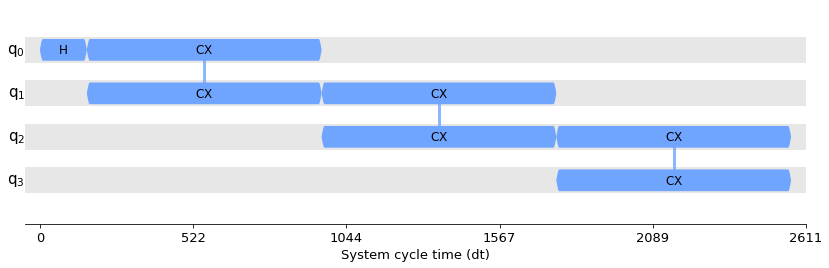

In [58]:
pm = PassManager(
    [
        ALAPSchedule(durations, clbit_write_latency=1600, conditional_latency=0), 
        PadDelay(),
    ]
)
qc_scheduled = pm.run(ghz4)

timeline_drawer(qc_scheduled)

`DynamicalDecoupling` pass. The pass configuration is same as before, but implementation has been overhauled.

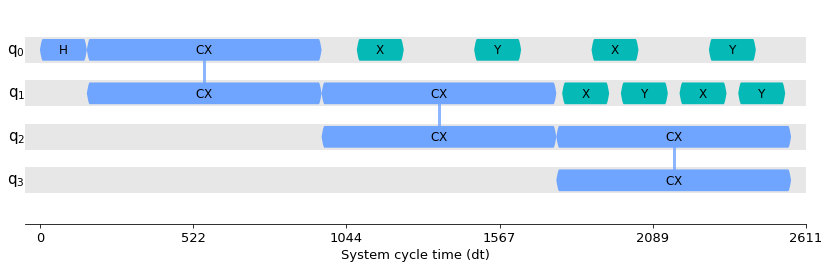

In [60]:
pm = PassManager(
    [
        ALAPSchedule(durations, clbit_write_latency=1600, conditional_latency=0), 
        DynamicalDecoupling(durations, dd_sequence),
    ]
)
qc_scheduled = pm.run(ghz4)

timeline_drawer(qc_scheduled)

In addition, DD pass now takes `pulse_alignment` constraint.

In [61]:
qc_scheduled.draw()

┌───┐            ┌────────────────┐      ┌───┐      »
q_0: ───────┤ H ├─────────■──┤ Delay(120[dt]) ├──────┤ X ├──────»
      ┌─────┴───┴──────┐┌─┴─┐└────────────────┘┌─────┴───┴─────┐»
q_1: ─┤ Delay(160[dt]) ├┤ X ├────────■─────────┤ Delay(20[dt]) ├»
      ├────────────────┤└───┘      ┌─┴─┐       └───────────────┘»
q_2: ─┤ Delay(960[dt]) ├───────────┤ X ├───────────────■────────»
     ┌┴────────────────┤           └───┘             ┌─┴─┐      »
q_3: ┤ Delay(1760[dt]) ├─────────────────────────────┤ X ├──────»
     └─────────────────┘                             └───┘      »
«     ┌────────────────┐      ┌───┐      ┌────────────────┐      ┌───┐      »
«q_0: ┤ Delay(240[dt]) ├──────┤ Y ├──────┤ Delay(240[dt]) ├──────┤ X ├──────»
«     └─────┬───┬──────┘┌─────┴───┴─────┐└─────┬───┬──────┘┌─────┴───┴─────┐»
«q_1: ──────┤ X ├───────┤ Delay(40[dt]) ├──────┤ Y ├───────┤ Delay(40[dt]) ├»
«           └───┘       └───────────────┘      └───┘       └───────────────┘»
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«     ┌────────────────┐      ┌───┐      ┌────────────────┐                 
«q_0: ┤ Delay(240[dt]) ├──────┤ Y ├──────┤ Delay(120[dt]) ├─────────────────
«     └─────┬───┬──────┘┌─────┴───┴─────┐└─────┬───┬──────┘┌───────────────┐
«q_1: ──────┤ X ├───────┤ Delay(40[dt]) ├──────┤ Y ├───────┤ Delay(20[dt]) ├
«           └───┘       └───────────────┘      └───┘       └───────────────┘
«q_2: ──────────────────────────────────────────────────────────────────────
«                                                                           
«q_3: ──────────────────────────────────────────────────────────────────────
«

In [64]:
pm = PassManager(
    [
        ALAPSchedule(durations, clbit_write_latency=1600, conditional_latency=0), 
        DynamicalDecoupling(durations, dd_sequence, pulse_alignment=16),
    ]
)
qc_scheduled = pm.run(ghz4)

qc_scheduled.draw()

┌───┐            ┌────────────────┐      ┌───┐      »
q_0: ───────┤ H ├─────────■──┤ Delay(112[dt]) ├──────┤ X ├──────»
      ┌─────┴───┴──────┐┌─┴─┐└────────────────┘┌─────┴───┴─────┐»
q_1: ─┤ Delay(160[dt]) ├┤ X ├────────■─────────┤ Delay(16[dt]) ├»
      ├────────────────┤└───┘      ┌─┴─┐       └───────────────┘»
q_2: ─┤ Delay(960[dt]) ├───────────┤ X ├───────────────■────────»
     ┌┴────────────────┤           └───┘             ┌─┴─┐      »
q_3: ┤ Delay(1760[dt]) ├─────────────────────────────┤ X ├──────»
     └─────────────────┘                             └───┘      »
«     ┌────────────────┐      ┌───┐      ┌────────────────┐      ┌───┐      »
«q_0: ┤ Delay(240[dt]) ├──────┤ Y ├──────┤ Delay(256[dt]) ├──────┤ X ├──────»
«     └─────┬───┬──────┘┌─────┴───┴─────┐└─────┬───┬──────┘┌─────┴───┴─────┐»
«q_1: ──────┤ X ├───────┤ Delay(32[dt]) ├──────┤ Y ├───────┤ Delay(64[dt]) ├»
«           └───┘       └───────────────┘      └───┘       └───────────────┘»
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«     ┌────────────────┐      ┌───┐      ┌────────────────┐                 
«q_0: ┤ Delay(240[dt]) ├──────┤ Y ├──────┤ Delay(112[dt]) ├─────────────────
«     └─────┬───┬──────┘┌─────┴───┴─────┐└─────┬───┬──────┘┌───────────────┐
«q_1: ──────┤ X ├───────┤ Delay(32[dt]) ├──────┤ Y ├───────┤ Delay(16[dt]) ├
«           └───┘       └───────────────┘      └───┘       └───────────────┘
«q_2: ──────────────────────────────────────────────────────────────────────
«                                                                           
«q_3: ──────────────────────────────────────────────────────────────────────
«